# Epilepsy Prediction
## Milestone 3 

November 5, 2016

- Rick Farmer
- Shivas Jayaram
- Sean Keery

## Summation

We performed Exploratory Data Analysis on three distinct datasets.  We briefly describe and summarize the data inline as we create visualizations further down the page to create a more logical flow of our findings.


## Key Findings

We looked for patterns of when seizures happen and examined factors related to the onset of seizures to evaluate which predictors may be of most value within the various datasets we examined.  

Some interesting findings include:

- All of our datasets were high-dimensional and we will need to do some dimensional reduction as we move forward.
- Time-series is present in all of the datasets explored.
- We have some clinical drug trial data that explore placebo versus drug efficacy that we will use to classify people that do have seizures and are treatable with the drug vs. people that receive placebo and have their seizures resolved regardless.
- We have EEG signal data of patients who have epilepsy and readings when they have seizures.  Analysis this data and comparing to new patients with EEG data during a seizure we can predict if they have epilepsy or not.
- At the core, we are trying to solve for classification of patients that have seizures, but may not be epileptic.

## Note

We explored the data separately to ensure that we had an unbiased view into each dataset.  Going forward we will discard data that doesn't inform our finding for the goals of categorization.



In [11]:
import time
import random
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
from itertools import combinations

from bs4 import BeautifulSoup
import urllib
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries
import requests

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

from mpl_toolkits.mplot3d import Axes3D

from __future__ import division # Python 2.7 uses integer division by default, so that 5 / 2 equals 2, this sfixes that

%matplotlib inline

## Load and Examine the Data

### Seizure Counts for Epileptics Data Description

Thall and Vail (1990) give a data set on two-week seizure counts for 59 epileptics. The number of seizures was recorded for a baseline period of 8 weeks, and then patients were randomly assigned to a treatment group or a control group. Counts were then recorded for four successive two-week periods. The subject's age is the only covariate.

#### Format
- **index** = order of the original data
- **y** = the seizure count for the 2-week period
- **trt** = treatment, administered, either "placebo" or "progabide"
- **base** = the counts in the baseline 8-week period
- **age** = subject's age, in years
- **V4** = 0 or 1 indicator variable of period 4
- **subject** = subject number, 1 to 59
- **period** = period observed, 1 to 4
- **lbase** = log-counts for the baseline period, centred to have zero mean.
- **lage** = log-ages, centered to have zero mean

In [23]:
# Open the file containing the  data
epil_df = pd.read_csv('data/epil.csv')

# Display the dimensions of the data with a pretty format
print "Data dimensions:"
print epil_df.shape
print "\n"

# Clean-up the data by filling missing values with the mean
epil_df.fillna(epil_df.mean())

# Display the first five rows of data
print "First five rows:"
print epil_df.head(5)
print "\n"

# Summarize the data
epil_df.describe()

Data dimensions:
(236, 10)


First five rows:
   Unnamed: 0  y      trt  base  age  V4  subject  period     lbase      lage
0           1  5  placebo    11   31   0        1       1 -0.756354  0.114204
1           2  3  placebo    11   31   0        1       2 -0.756354  0.114204
2           3  3  placebo    11   31   0        1       3 -0.756354  0.114204
3           4  3  placebo    11   31   1        1       4 -0.756354  0.114204
4           5  3  placebo    11   30   0        2       1 -0.756354  0.081414




,Unnamed: 0,y,base,age,V4,subject,period,lbase,lage
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.00000,2.360000e+02,2.360000e+02
mean,118.500000,8.254237,31.220339,28.338983,0.250000,30.000000,2.50000,-3.389830e-11,1.694910e-11
std,68.271517,12.346891,26.705051,6.261290,0.433933,17.065581,1.12041,7.461263e-01,2.224570e-01
min,1.000000,0.000000,6.000000,18.000000,0.000000,1.000000,1.00000,-1.362490e+00,-4.294118e-01
25%,59.750000,2.750000,12.000000,23.000000,0.000000,15.000000,1.75000,-6.693424e-01,-1.842893e-01
50%,118.500000,4.000000,22.000000,28.000000,0.000000,30.000000,2.50000,-6.320661e-02,1.242100e-02
75%,177.250000,9.000000,41.000000,32.000000,0.250000,45.000000,3.25000,5.593230e-01,1.459524e-01
max,236.000000,102.000000,151.000000,42.000000,1.000000,59.000000,4.00000,1.863031e+00,4.178861e-01


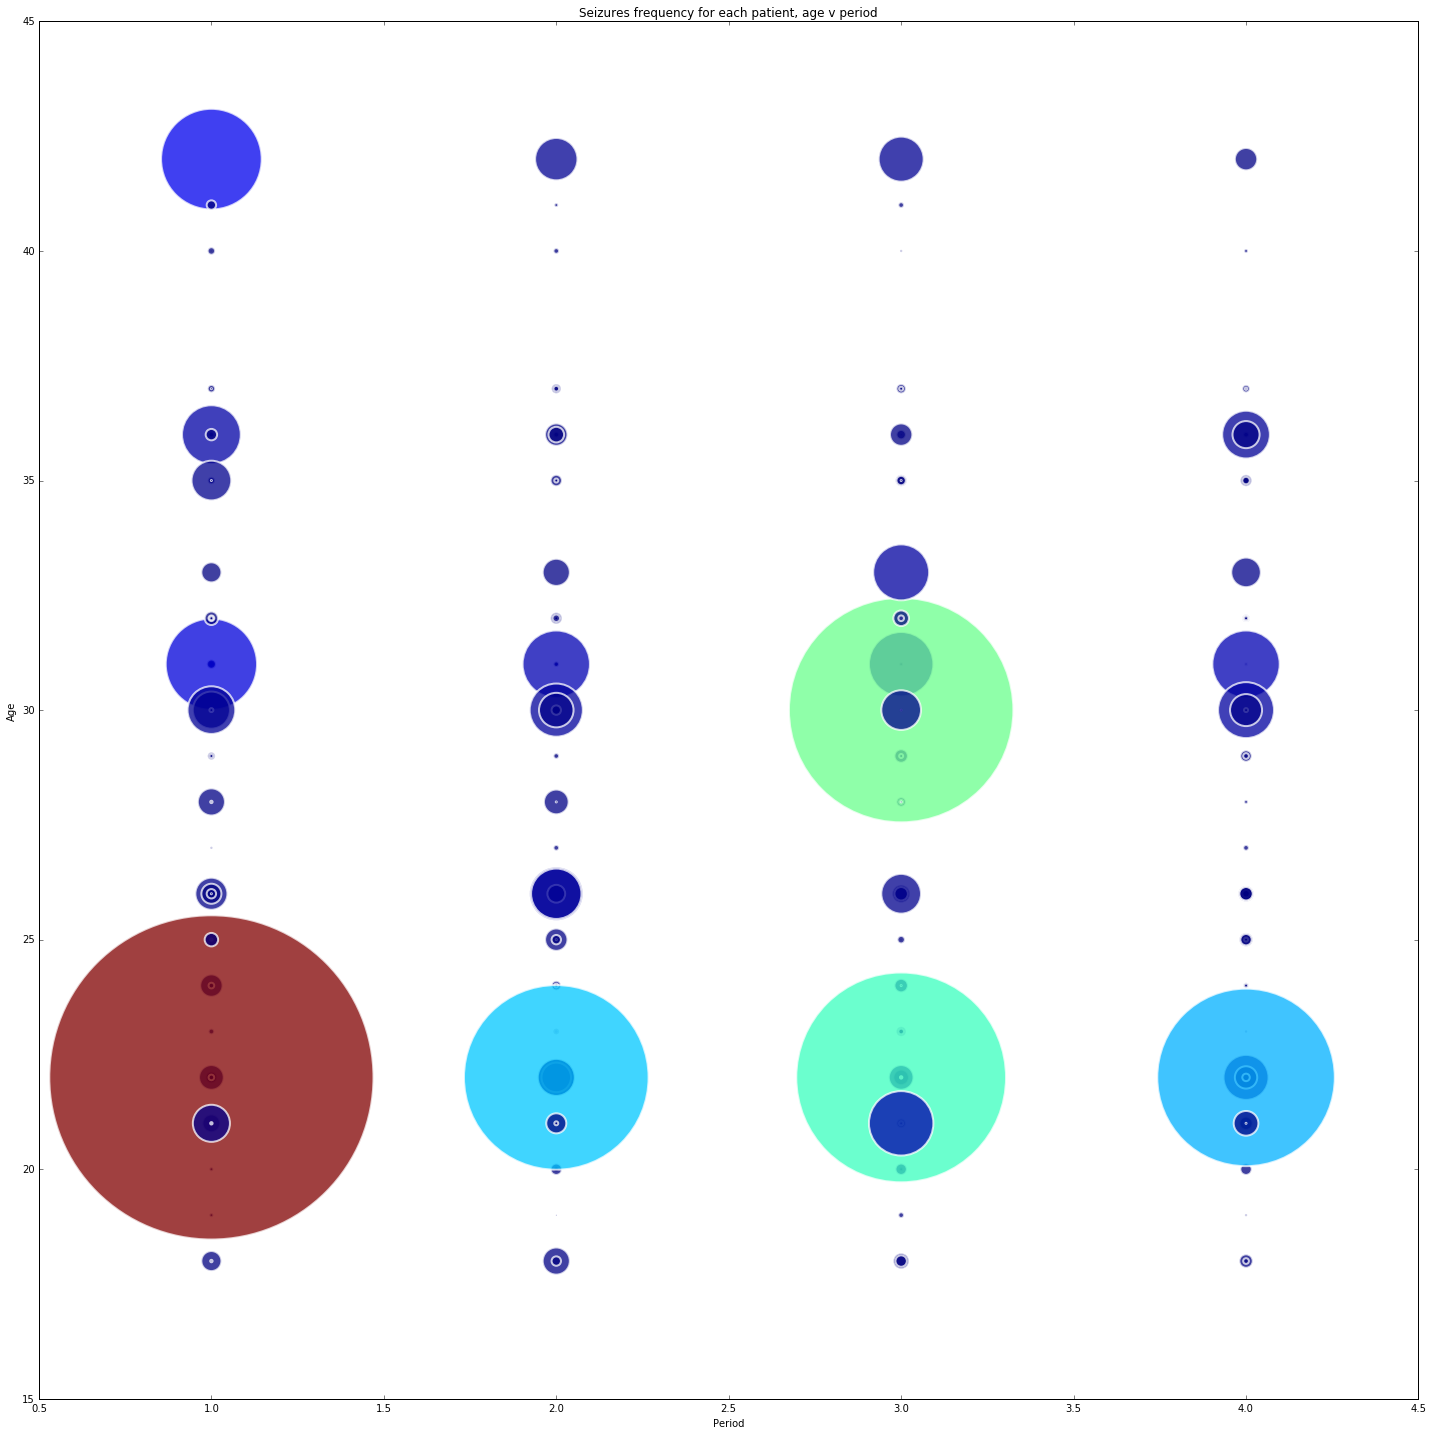

In [24]:
# Assign the patients in a given age range, and the coordinates for plotting
age, y, period =  epil_df['age'], epil_df['y']**2.5, epil_df['period']

# Create the figure
fig = plt.figure(figsize=(20,20))
ax1 = plt.axes()
ax1.scatter(period, age, s=y, c=y, linewidths=2, edgecolor='w').set_alpha(0.75)
ax1.set_xlabel('Period')
ax1.set_ylabel('Age')
ax1.set_title('Seizures frequency for each patient, age v period')
plt.tight_layout()
plt.show()

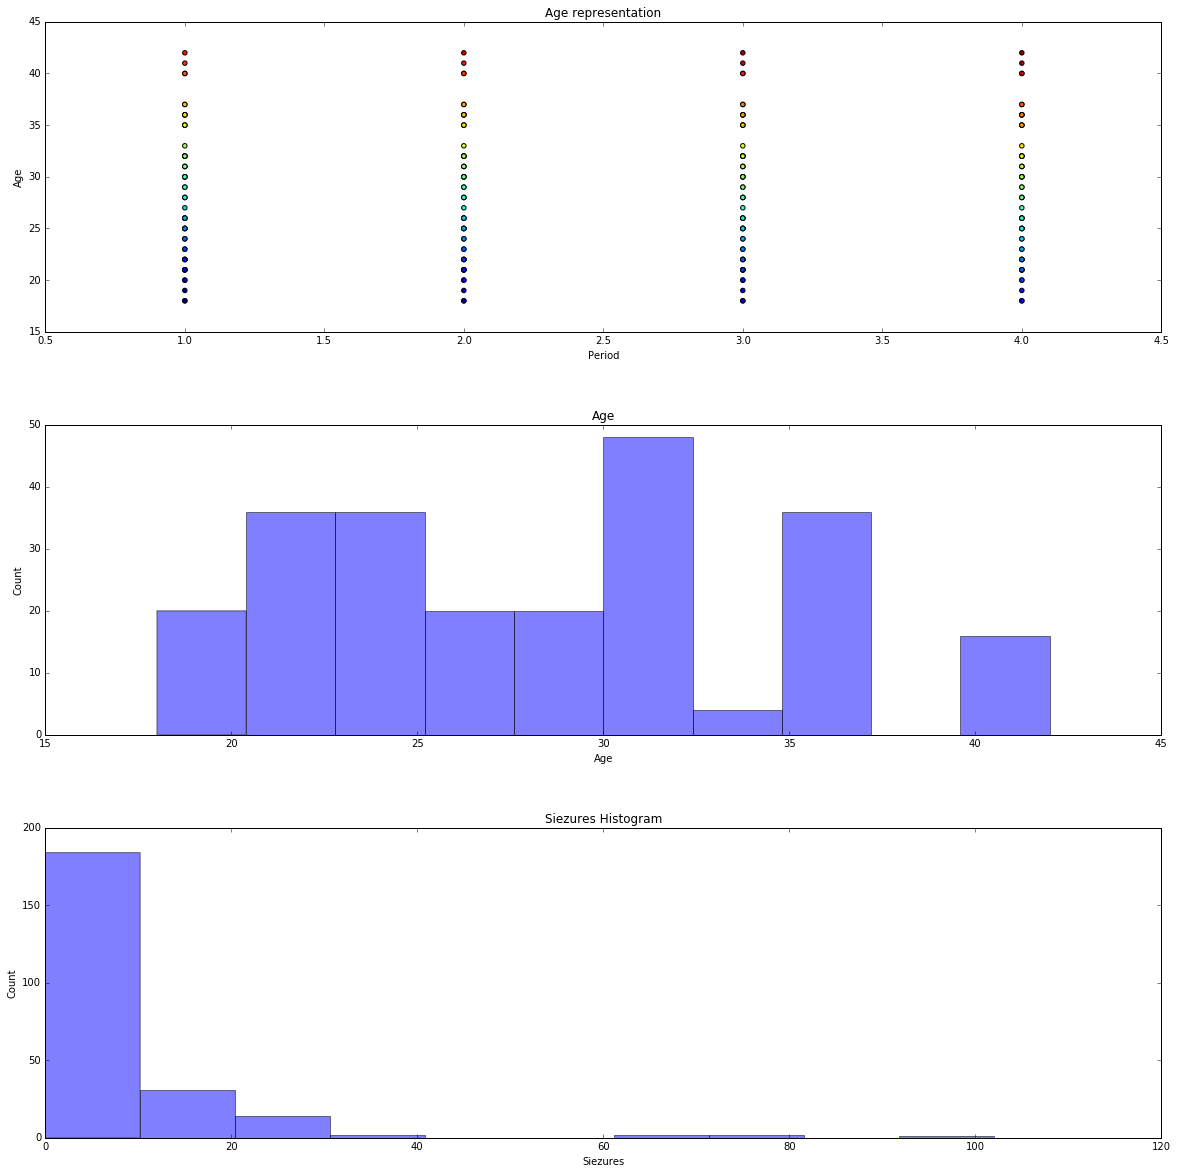

In [36]:
# Assign the patients in a given age range, and the coordinates for plotting
age, count, period =  epil_df['age'], epil_df['y'], epil_df['period']

# Create a new figure window to draw in, with a larger figure size to fill the space
fig = plt.figure(figsize=(20, 20)) 

# Add a subplot into the predefined 3 rows & 1 col figure
ax = fig.add_subplot(3, 1, 1) 
ax.set_title("Age representation") # Add the title to each subplot
ax.set_xlabel("Period") # Add the x-axis label to this subplot
ax.set_ylabel("Age") # Add the y-axis label to this subplot

# Add a subplot into the predefined 3 rows & 1 col figure
ax = fig.add_subplot(3, 1, 2)
ax.set_title("Age") # Add the title to each subplot
ax.set_xlabel("Age") # Add the x-axis label to this subplot
ax.set_ylabel("Count") # Add the y-axis label to this subplot    
    
# Add a subplot into the predefined 3 rows & 1 col figure
ax = fig.add_subplot(3, 1, 3)
ax.set_title("Siezures Histogram") # Add the title to each subplot
ax.set_xlabel("Siezures") # Add the x-axis label to this subplot
ax.set_ylabel("Count") # Add the y-axis label to this subplot  
    
# Finally, add the x, y data in the form of a scatter plot and set the color scheme, e.g c=    
fig.axes[0].scatter(period, age, c=(period+age)) 
fig.axes[1].hist(age, bins=10, alpha=0.5)
fig.axes[2].hist(count, bins=10, alpha=0.5)

fig.subplots_adjust(wspace=0.1, hspace=0.3) # Spread out the subplots so they don't overlap one another

# Epilepsy Prediction

In [88]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain

In [155]:
#Load the data 
seizure_raw = pd.read_csv('data/seizure.csv', delimiter=',')
#Check out the data - sanity check
# print seizure_raw.shape
# seizure_raw.head()

*ID*  Patient identification number

*Y1*  Number of epilepsy attacks patients have during the first follow-up period

*Y2*  Number of epilepsy attacks patients have during the second follow-up period

*Y3*  Number of epilepsy attacks patients have during the third follow-up period

*Y4*  Number of epilepsy attacks patients have during the forth follow-up period

*Base*  Number of epileptic attacks recorded during 8 week period prior to randomization

*Age*  Age of the patients

*Treatment*  A factor with levels placebo progabide indicating whether the anti-epilepsy drug Progabide has been applied or not (0=Placebo, 1=Progabide)

In [156]:
#clean up data
seizure_raw.columns=['ID','y1','y2','y3','y4','treatment','base','age']
print seizure_raw.shape
seizure_raw.head()

(59, 8)


,ID,y1,y2,y3,y4,treatment,base,age
0,1,5,3,3,3,0,11,31
1,2,3,5,3,3,0,11,30
2,3,2,4,0,5,0,6,25
3,4,4,4,1,4,0,8,36
4,5,7,18,9,21,0,66,22


In [157]:
#let's take a look at the summary statistics of the data
seizure_raw.describe()

,ID,y1,y2,y3,y4,treatment,base,age
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,30.000000,8.949153,8.355932,8.440678,7.338983,0.525424,31.237288,28.847458
std,17.175564,14.835214,10.187488,14.148561,9.637588,0.503640,26.883747,7.619878
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,18.000000
25%,15.500000,2.000000,3.000000,2.000000,3.000000,0.000000,12.000000,22.500000
50%,30.000000,4.000000,5.000000,4.000000,5.000000,1.000000,22.000000,28.000000
75%,44.500000,10.500000,11.500000,8.000000,8.000000,1.000000,41.500000,33.500000
max,59.000000,102.000000,65.000000,76.000000,63.000000,1.000000,151.000000,57.000000


# Notes here

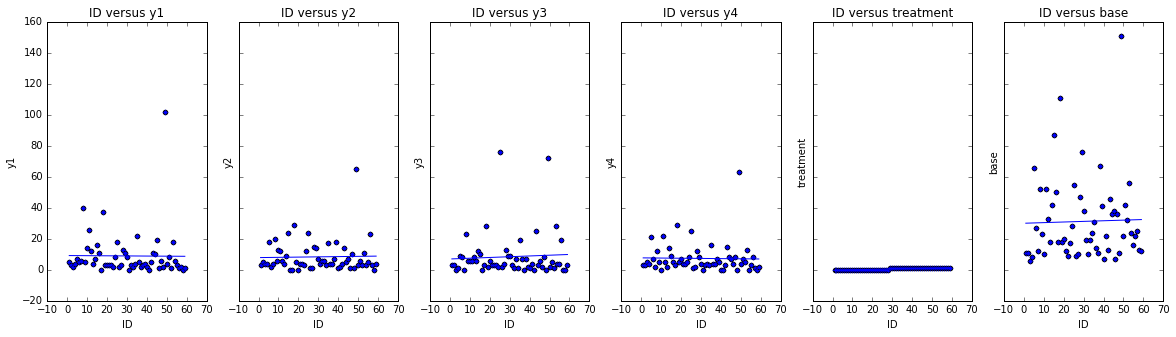

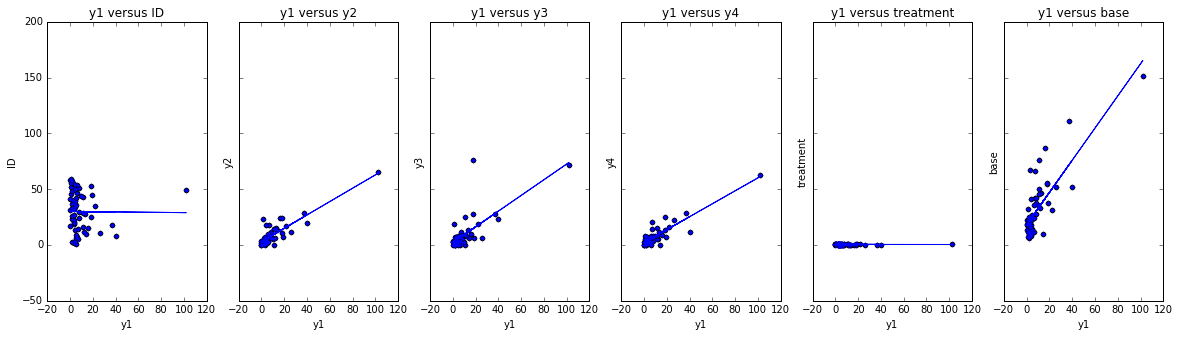

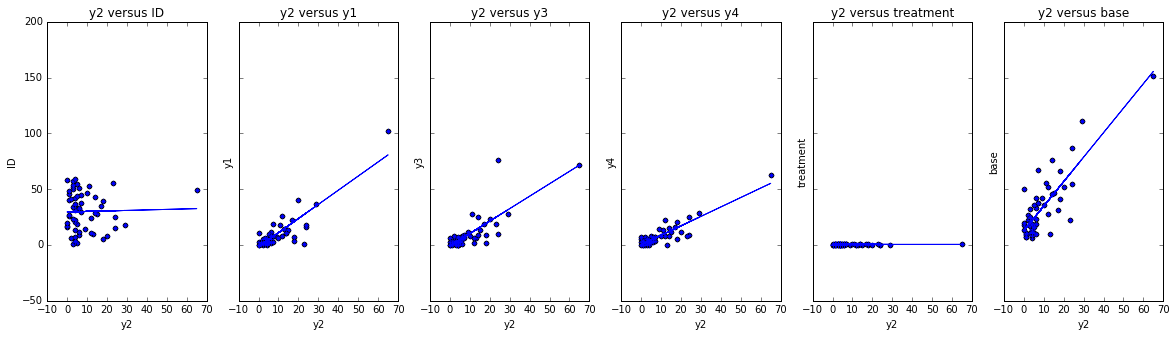

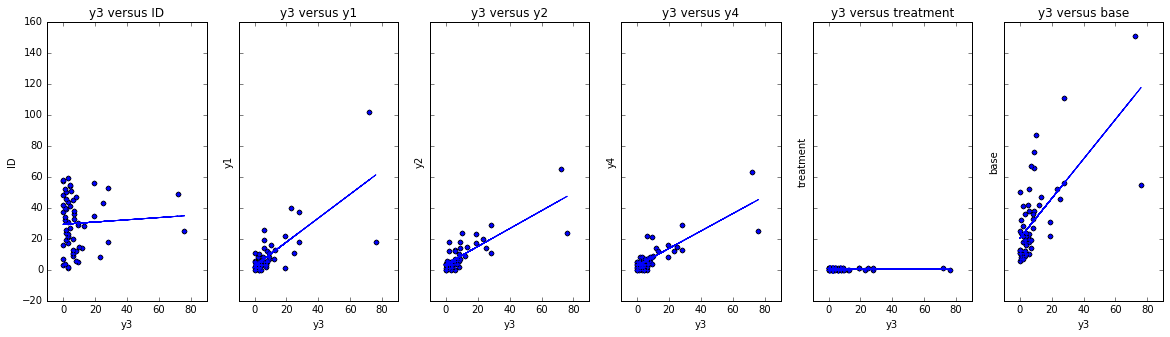

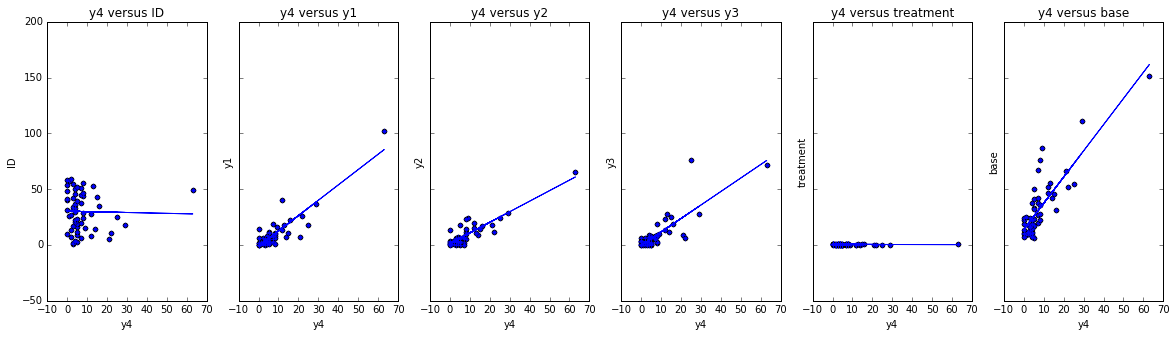

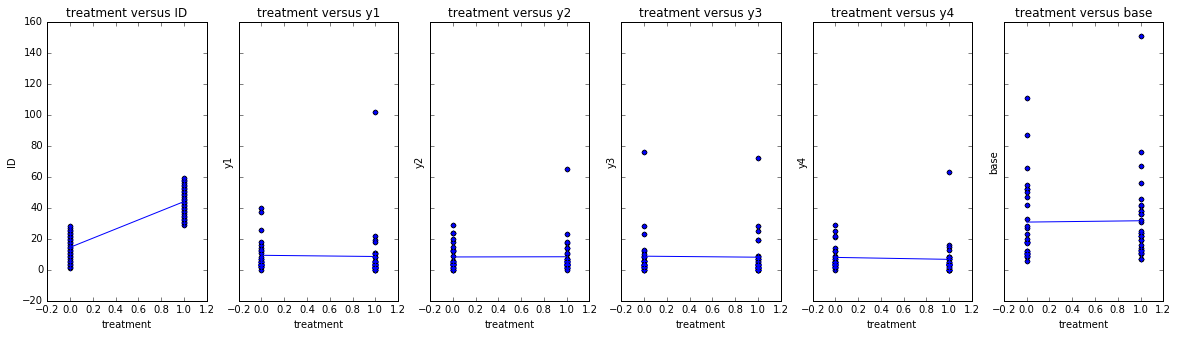

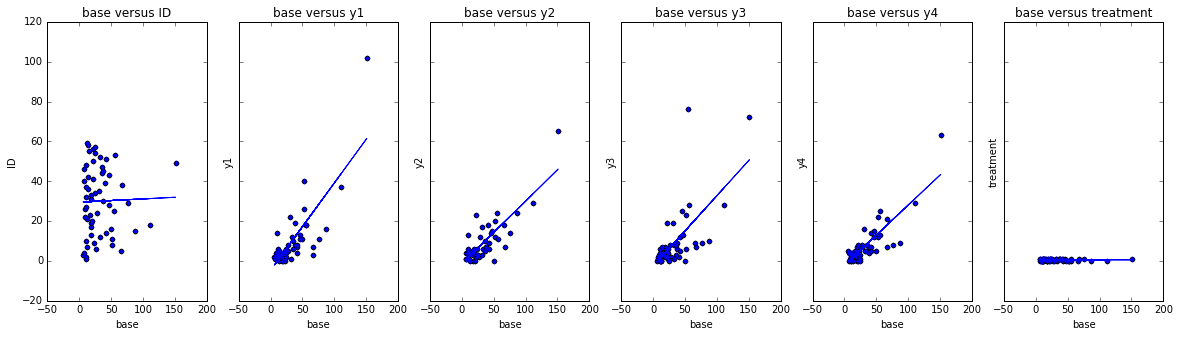

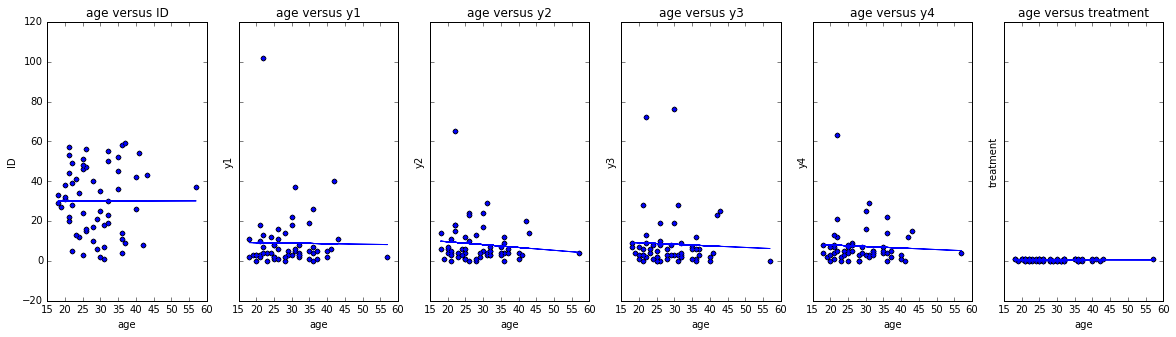

In [158]:
columns=list(seizure_raw)
for x_column in columns:
# x_column = columns[0]
    cols = columns[:]
    cols.remove(x_column)

    fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(20,5))

    for y_column, ax in zip(cols, axes):
        if y_column != x_column:
            x = seizure_raw[x_column]
            y = seizure_raw[y_column]
            fit = np.polyfit(x, y, 1)
            fitx = np.poly1d(fit)
            ax.plot(x, y, 'b+', x, fitx(x),'b-')
            ax.set_xlabel(x_column)
            ax.set_ylabel(y_column)
            ax.set_title(x_column + ' versus ' + y_column)
            ax.scatter(x,y)

So we do see the trendlines decreasing in the weeks where treatments were in place above.

In [159]:
# # I'm going to add a basey column which sums all the y periodicity
seizure_raw['basey'] = seizure_raw['y1']+seizure_raw['y2']+seizure_raw['y3']+seizure_raw['y4']

In [165]:
# let's tweak the data a bit more
seizure_df=pd.melt(seizure_raw,id_vars=['ID', 'treatment','age'], var_name='quantity').sort_values(by=['ID', 'quantity'])
seizure_df.head()

,ID,treatment,age,quantity,value
236,1,0,31,base,11
295,1,0,31,basey,14
0,1,0,31,y1,5
59,1,0,31,y2,3
118,1,0,31,y3,3


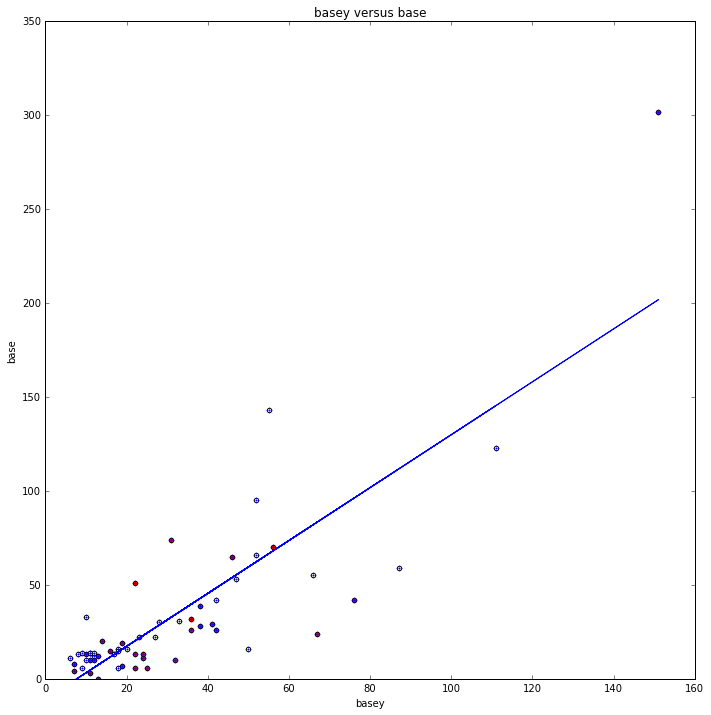

In [187]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['base']
y = seizure_raw['basey']
z = seizure_raw['treatment']
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel(x_column)
ax.set_ylabel(y_column)
ax.set_title(x_column + ' versus ' + y_column)
#   ax.scatter(x,y)
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide')
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo')
plt.tight_layout()
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
plt.show()

The red dots show that treatment is effectice in this sample

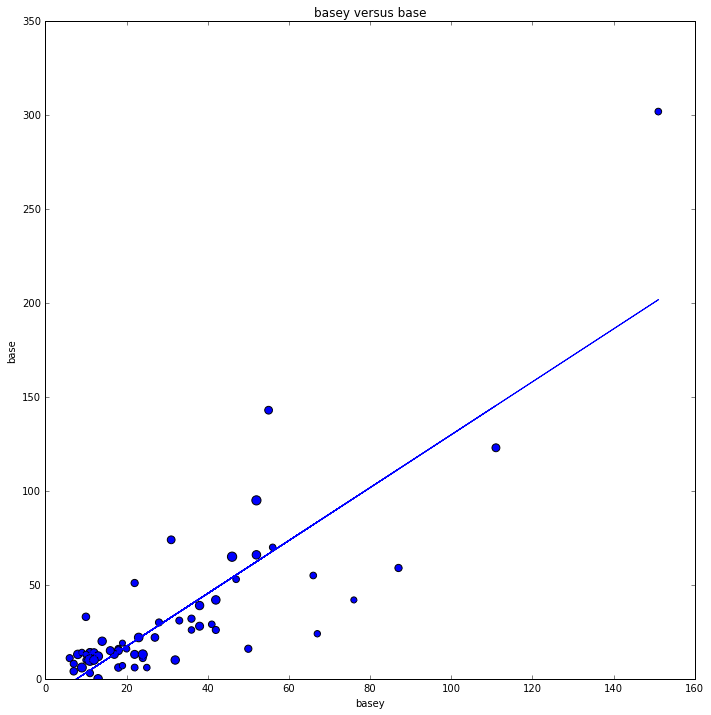

In [183]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['base']
y = seizure_raw['basey']
z = seizure_raw['age']
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel(x_column)
ax.set_ylabel(y_column)
ax.set_title(x_column + ' versus ' + y_column)
#   ax.scatter(x,y)
#Plot age as dot size
ax.scatter(x, y, s=z*2)
plt.tight_layout()
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
plt.show()

I really should plot it the median of base against y1-y4 over time by patient

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['base']
y = seizure_raw['basey']
z = seizure_raw['age']
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel(x_column)
ax.set_ylabel(y_column)
ax.set_title(x_column + ' versus ' + y_column)
#   ax.scatter(x,y)
#Plot age as dot size
ax.scatter(x, y, s=z*2)
plt.tight_layout()
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
plt.show()

And I should look at the deltas

In [236]:
deltas_df = pd.concat([seizure_raw['ID'], seizure_raw['y1'], seizure_raw['y2'], seizure_raw['y3'], seizure_raw['y4'], seizure_raw['base'], seizure_raw['treatment'],seizure_raw['age']], axis=1)
# deltas_df['delta1'] = seizure_raw.apply(seizure_raw['y1']-(seizure_raw['base'])/4)
deltas_df['basey'] = seizure_raw['y1']+seizure_raw['y2']+seizure_raw['y3']+seizure_raw['y4']
deltas_df.head()

,ID,y1,y2,y3,y4,base,treatment,age,basey
0,1,5,3,3,3,11,0,31,14
1,2,3,5,3,3,11,0,30,14
2,3,2,4,0,5,6,0,25,11
3,4,4,4,1,4,8,0,36,13
4,5,7,18,9,21,66,0,22,55


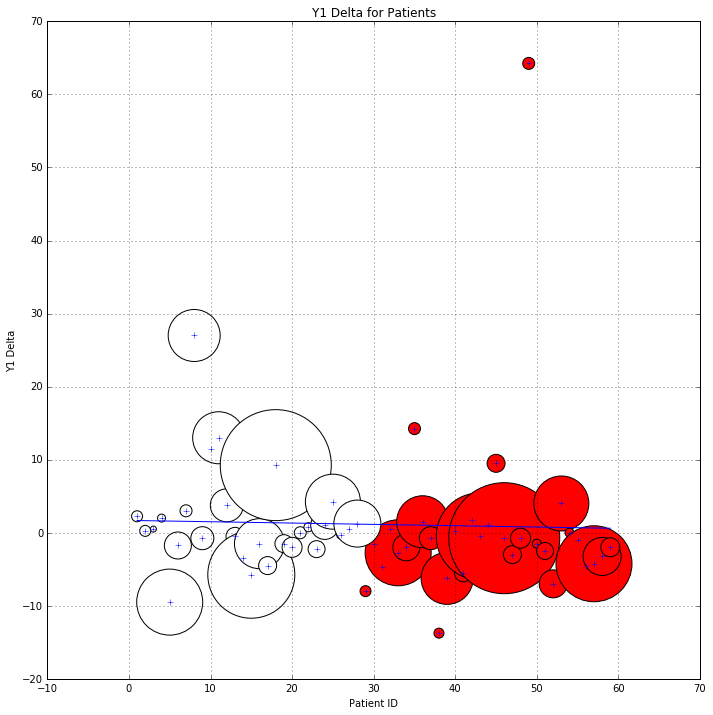

In [243]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y1']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y1 Delta')
ax.set_title('Y1 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

I was trying to show if the patient had a large baseline to begin with above.  The trendline is down.

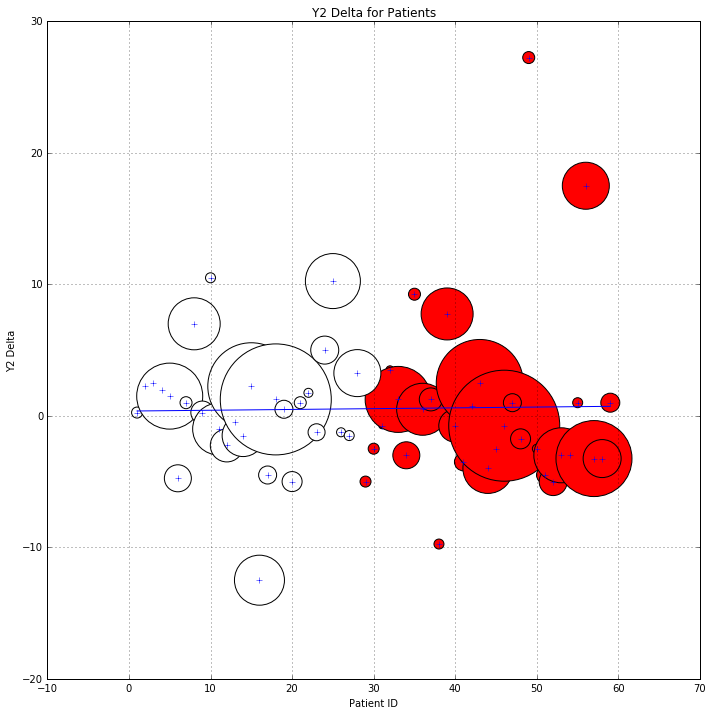

In [242]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y2']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y2 Delta')
ax.set_title('Y2 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

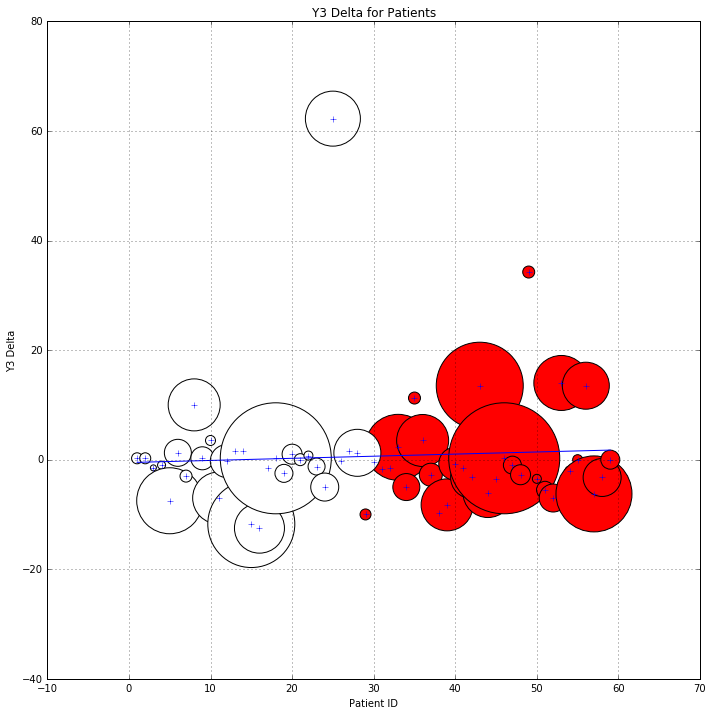

In [241]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y3']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y3 Delta')
ax.set_title('Y3 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

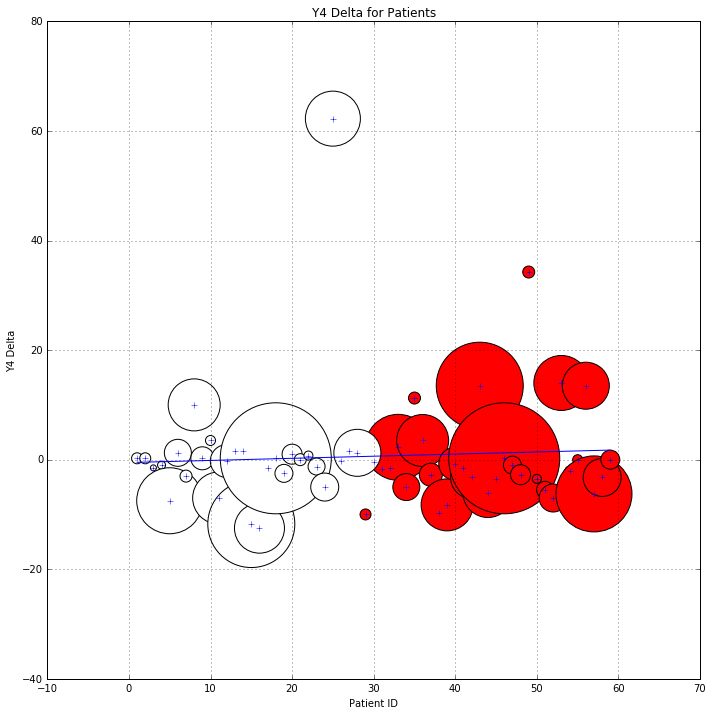

In [240]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y3']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y4 Delta')
ax.set_title('Y4 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

Not so conclusive for the other weeks.  Need to look at age perhaps?

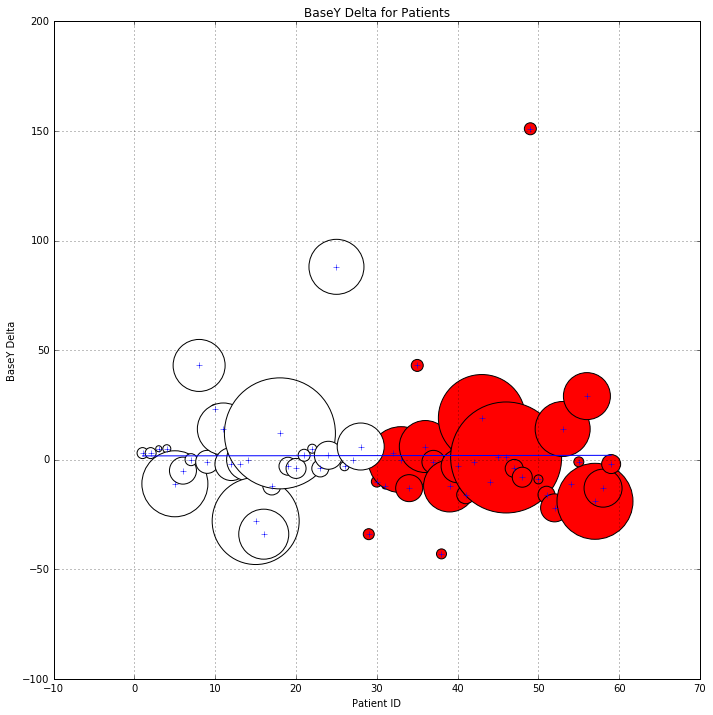

In [239]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['basey']-(seizure_raw['base'])
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('BaseY Delta')
ax.set_title('BaseY Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

Overall pretty flat.

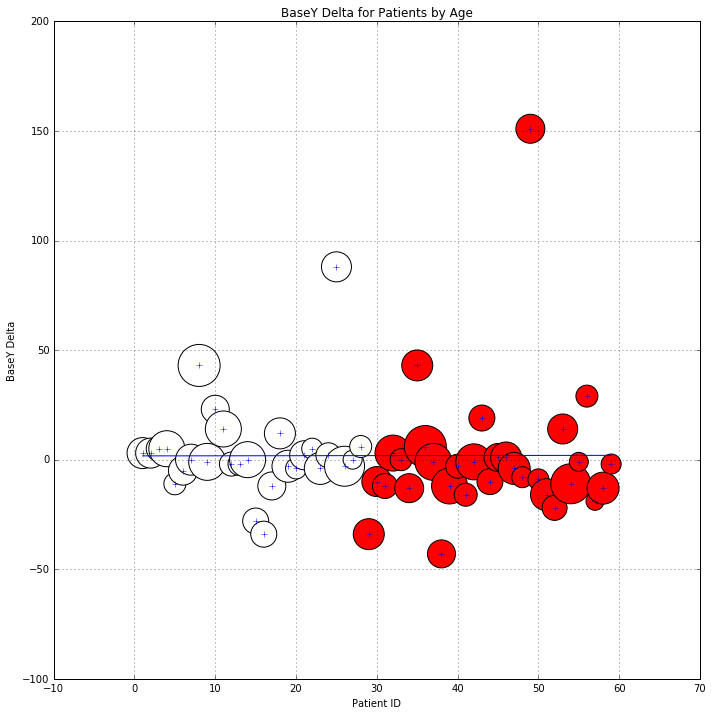

In [238]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['basey']-(seizure_raw['base'])
z = seizure_raw['treatment']
size = (seizure_raw['age'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('BaseY Delta')
ax.set_title('BaseY Delta for Patients by Age')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

I need to visualize this by time period using the reshaped seizures_df

# Epilepsy Prediction

In [1]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
%matplotlib inline

#### Summary of data

Dataset for this exploratory data analysis is from Children’s Hospital Boston and contains 24 cases of children who have epilepsy. For this analysis we are only looking at one patient “chb03”and one EEG reading. The details of the file we analyzed are:

- File Name: chb01_03.edf
- File Start Time: 13:43:04
- File End Time: 14:43:04
- Number of Seizures in File: 1
- Seizure Start Time: 2996 seconds
- Seizure End Time: 3036 seconds


Channels in EDF Files:
- Channel 1: FP1-F7
- Channel 2: F7-T7
- Channel 3: T7-P7
- Channel 4: P7-O1
- Channel 5: FP1-F3
- Channel 6: F3-C3
- Channel 7: C3-P3
- Channel 8: P3-O1
- Channel 9: FP2-F4
- Channel 10: F4-C4
- Channel 11: C4-P4
- Channel 12: P4-O2
- Channel 13: FP2-F8
- Channel 14: F8-T8
- Channel 15: T8-P8
- Channel 16: P8-O2
- Channel 17: FZ-CZ
- Channel 18: CZ-PZ
- Channel 19: P7-T7
- Channel 20: T7-FT9
- Channel 21: FT9-FT10
- Channel 22: FT10-T8
- Channel 23: T8-P8

Data Sampling Rate: 256 Hz

The signals were sampled at 256 samples per second so for 60 minutes of signal readings we have 921,600 readings for each channel. We visualized the raw data of all the signals and also the summarized signal reading to a per second average reading. We marked the regions where seizures occurred and can see how the EEG signals show spikes in that timeframe.


In [4]:
# Load EEG data for dataset 3
eeg_file = pyedflib.EdfReader("data/chb01_03.edf")
no_of_signals = eeg_file.signals_in_file
signal_labels = eeg_file.getSignalLabels()

In [5]:
# Extract the EEG signal data into a python array
sigbufs = np.zeros((no_of_signals, eeg_file.getNSamples()[0]))
for i in np.arange(no_of_signals):
    sigbufs[i, :] = eeg_file.readSignal(i)

# Clear the memory by removing the eeg file we read into memory
eeg_file._close()
del eeg_file

In [7]:
# Summarize our dataset
print "Shape of our singal data array:" , sigbufs.shape
print "Number of signals(Channels): " , no_of_signals
print "Signal/Channel Labels:"
print signal_labels

Shape of our singal data array: (23, 921600)
Number of signals(Channels):  23
Signal/Channel Labels:
[u'FP1-F7', u'F7-T7', u'T7-P7', u'P7-O1', u'FP1-F3', u'F3-C3', u'C3-P3', u'P3-O1', u'FP2-F4', u'F4-C4', u'C4-P4', u'P4-O2', u'FP2-F8', u'F8-T8', u'T8-P8', u'P8-O2', u'FZ-CZ', u'CZ-PZ', u'P7-T7', u'T7-FT9', u'FT9-FT10', u'FT10-T8', u'T8-P8']


In [15]:
# Load the EEG data into dataframe
eeg_df = pd.DataFrame(data=sigbufs.transpose(),columns=signal_labels)
eeg_df.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8
0,-17.777778,39.267399,-3.711844,8.400488,-0.586081,4.102564,37.704518,-15.042735,-17.387057,-45.128205,...,-106.862027,-59.97558,180.317460,-18.559219,85.372405,4.102564,20.903541,-9.181929,-39.65812,-59.97558
1,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.19536,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.19536,0.19536
2,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.19536,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.19536,0.19536
3,0.586081,0.195360,0.195360,0.195360,0.195360,0.195360,0.586081,-0.195360,0.195360,0.586081,...,-0.976801,0.19536,2.148962,0.586081,0.586081,0.195360,1.367521,-0.195360,-0.19536,0.19536
4,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.19536,2.148962,0.195360,0.195360,0.195360,-0.195360,0.195360,0.19536,0.19536


In [10]:
print "Shape of EEG DF:" , eeg_df.shape
row_count = eeg_df.shape[0]

Shape of EEG DF: (921600, 23)


In [11]:
# Describe the data
eeg_df.describe()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8
count,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,...,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000,921600.000000
mean,0.179297,0.169967,0.211526,0.212904,0.191500,0.178069,0.205915,0.202724,0.195028,0.178507,...,0.207375,0.195459,0.187872,0.177643,0.210702,0.179194,0.194553,0.221789,0.215459,0.195459
std,40.714261,32.894312,39.951937,33.216016,47.113506,47.234020,34.301307,42.481846,45.950161,46.201914,...,39.765019,46.414002,49.791142,55.202184,50.496161,39.951937,24.620918,48.208360,25.459858,46.414002
min,-480.000000,-281.904762,-313.943834,-205.714286,-513.211233,-431.159951,-316.678877,-386.227106,-536.263736,-554.236874,...,-547.203907,-721.074481,-378.412698,-540.170940,-491.721612,-309.255189,-226.031746,-512.429792,-289.328449,-721.074481
25%,-18.168498,-16.605617,-19.731380,-17.387057,-23.638584,-24.029304,-18.168498,-22.466422,-22.857143,-22.075702,...,-20.122100,-21.294261,-26.373626,-27.155067,-27.545788,-19.340659,-13.479853,-23.638584,-12.698413,-21.294261
50%,0.586081,0.586081,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.586081,...,0.195360,0.195360,0.195360,0.586081,-0.195360,0.195360,0.586081,-0.195360,0.195360,0.195360
75%,18.949939,17.387057,19.731380,17.777778,24.029304,25.592186,18.168498,22.857143,22.857143,23.247863,...,20.512821,21.684982,26.764347,28.327228,27.155067,20.122100,14.261294,23.638584,12.698413,21.684982
max,499.536020,305.738706,309.645910,198.681319,556.581197,349.499389,363.174603,343.247863,451.477411,395.213675,...,481.953602,476.483516,479.609280,595.262515,469.450549,314.334554,317.069597,485.470085,500.317460,476.483516


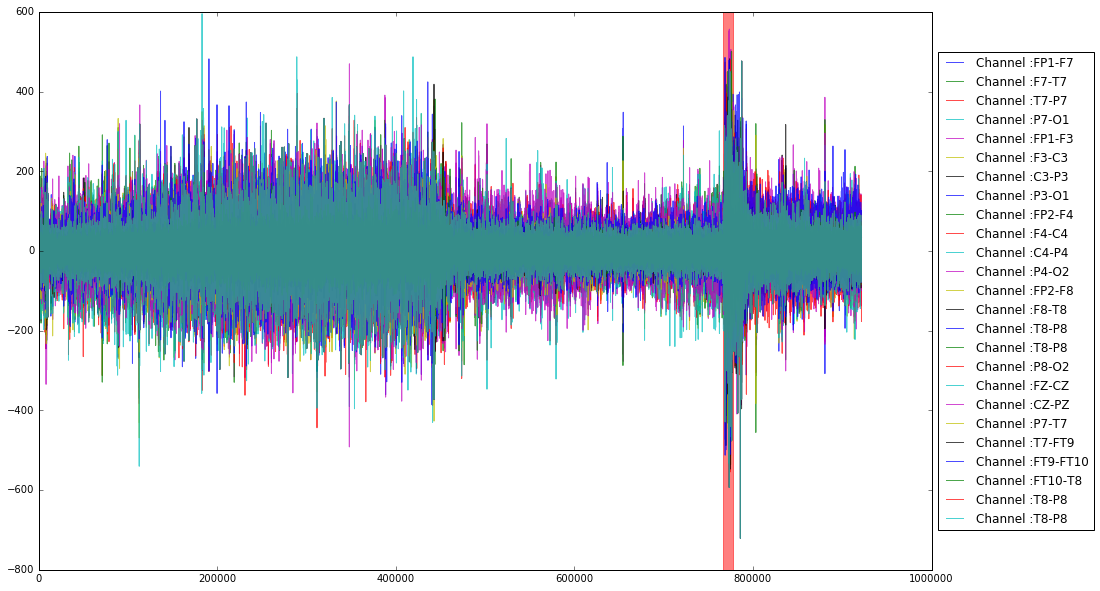

In [17]:
# Visualize using all the data for all channels
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for column in eeg_df.columns:
    ax.plot(range(row_count), eeg_df[column].values,label='Channel :'+column,alpha=0.7)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Signals where seizures occured
ax.axvspan(2996*256, 3036*256, alpha=0.5, color='red')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

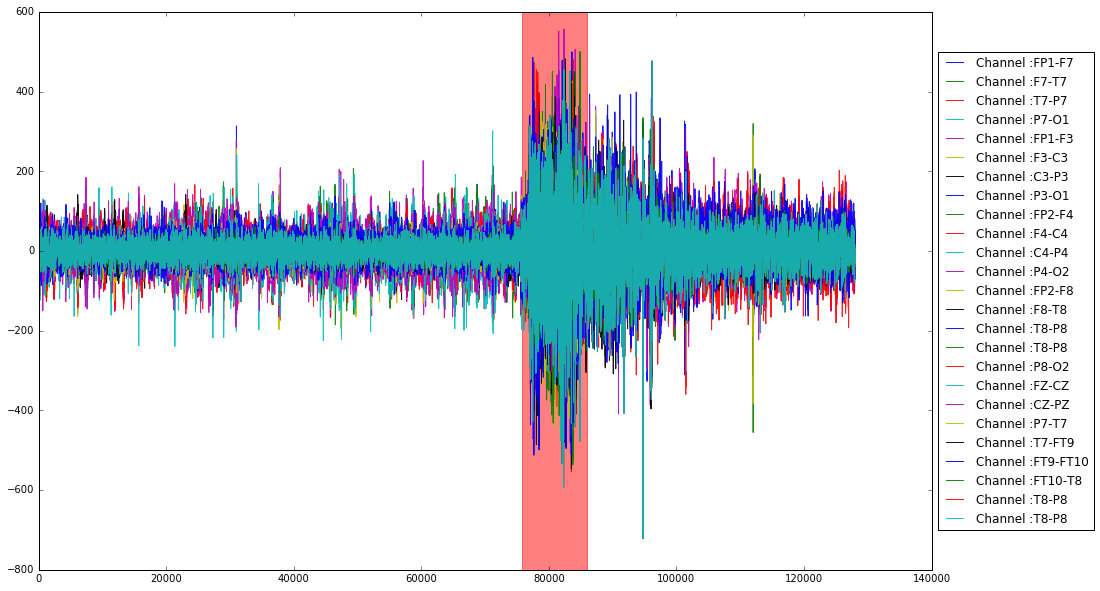

In [44]:
# Visualize using the data for all channels close to seizures

subset_eeg_df = eeg_df.iloc[2700*256:3200*256,:]
row_count = subset_eeg_df.shape[0]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for column in subset_eeg_df.columns:
    ax.plot(range(row_count), subset_eeg_df[column].values,label='Channel :'+column,alpha=0.9)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Signals where seizures occured
ax.axvspan((2996-2700)*256, (3036-2700)*256, alpha=0.5, color='red')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

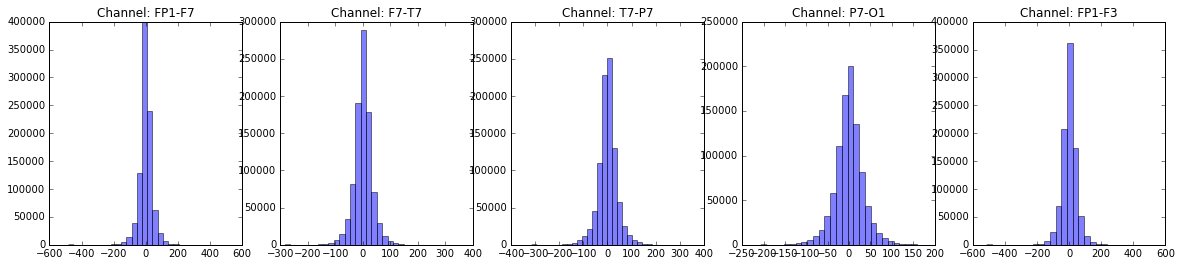

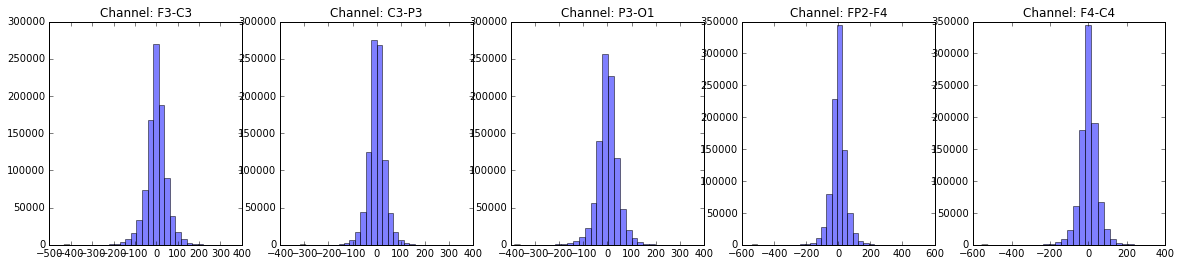

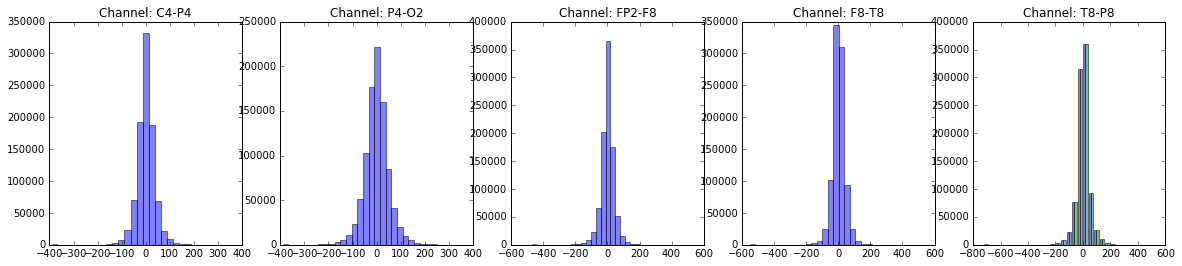

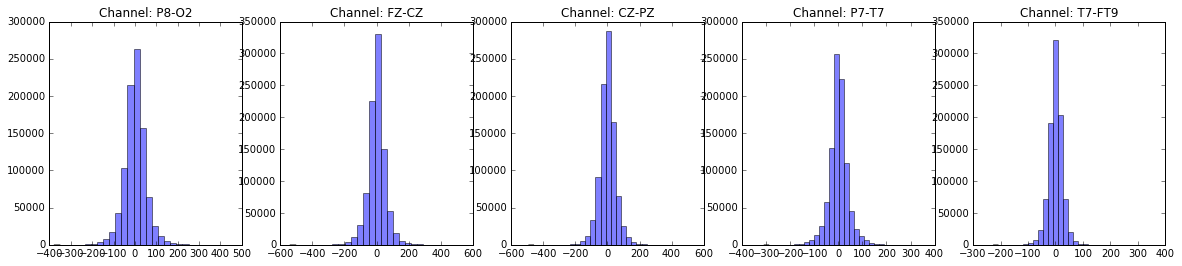

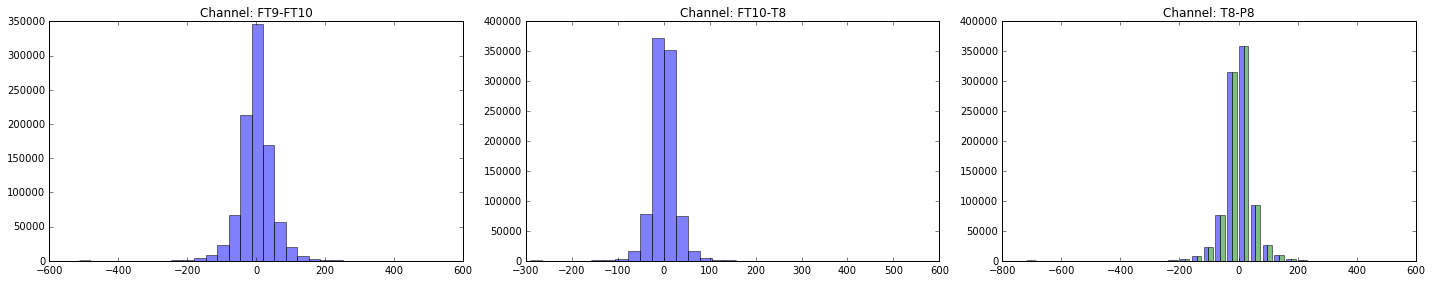

In [36]:
# Plot histograms of all the channels data

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
idx =0
for column in eeg_df.columns[:5]:
    ax[idx].hist(eeg_df[column].values, bins=30, alpha=0.5)
    ax[idx].set_title('Channel: '+column)
    idx = idx +1

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
idx =0
for column in eeg_df.columns[5:10]:
    ax[idx].hist(eeg_df[column].values, bins=30, alpha=0.5)
    ax[idx].set_title('Channel: '+column)
    idx = idx +1

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
idx =0
for column in eeg_df.columns[10:15]:
    ax[idx].hist(eeg_df[column].values, bins=30, alpha=0.5)
    ax[idx].set_title('Channel: '+column)
    idx = idx +1

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
idx =0
for column in eeg_df.columns[15:20]:
    ax[idx].hist(eeg_df[column].values, bins=30, alpha=0.5)
    ax[idx].set_title('Channel: '+column)
    idx = idx +1

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
idx =0
for column in eeg_df.columns[20:24]:
    ax[idx].hist(eeg_df[column].values, bins=30, alpha=0.5)
    ax[idx].set_title('Channel: '+column)
    idx = idx +1
    
plt.tight_layout()
plt.show() 

In [62]:
# The signals are sampled at 256 samples per second. 
# So let us average the samples to get one reading per second

row_count = eeg_df.shape[0]
summary_eeg = []

for i in range(0,row_count,255):
    summary = eeg_df.iloc[i:i+255,:].mean(axis=0)
    summary_eeg.append(summary)

summary_eeg_df = pd.DataFrame(np.asarray(summary_eeg), columns=eeg_df.columns)
print "Summarized signal data shape: " , summary_eeg_df.shape
summary_eeg_df.head()

Summarized signal data shape:  (3615, 23)


,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8
0,-10.081352,-9.549666,-3.840552,-1.781225,-0.095765,-11.008355,-11.438914,-2.614762,5.100050,-6.751802,...,9.794824,-1.243410,-20.198712,-6.878977,-17.299720,4.231272,-3.120400,2.060092,8.811128,-1.243410
1,10.801504,10.767794,3.966195,-0.555436,-0.878738,12.088582,5.893749,8.429601,-1.522277,8.820321,...,3.455960,3.135723,-1.275587,6.521966,3.661280,-3.575475,-1.479375,-2.803227,-0.104958,3.135723
2,-3.478944,-2.418636,-5.109244,-0.860351,-0.463502,5.188920,-5.311499,-11.860279,-0.368503,-1.998803,...,-2.973306,-3.158706,-5.512222,2.495248,2.513635,5.499964,-1.580502,5.755848,0.843496,-3.158706
3,3.983050,3.944744,8.147669,8.521535,-0.687208,1.955900,7.367761,16.366588,-6.681319,6.292131,...,7.262036,10.185544,12.241806,2.142833,6.143504,-7.756949,3.224592,-7.900979,-0.812852,10.185544
4,1.309296,-4.355383,-2.415571,-5.190452,1.146879,-4.330867,1.205104,-8.890804,11.000694,2.916613,...,-3.269027,-2.996289,-2.706696,7.565419,-9.151284,2.806292,1.623405,2.300654,-0.005363,-2.996289


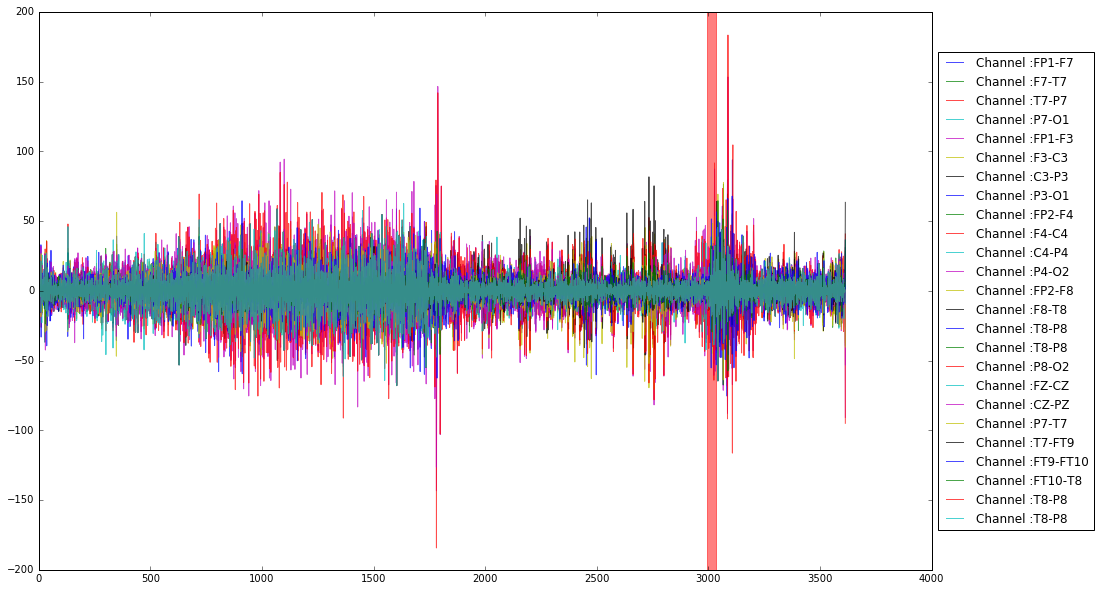

In [66]:
# Visualize using summarized data for all channels
row_count = summary_eeg_df.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for column in summary_eeg_df.columns:
    ax.plot(range(row_count), summary_eeg_df[column].values,label='Channel :'+column,alpha=0.7)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Signals where seizures occured
ax.axvspan(2996, 3036, alpha=0.5, color='red')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()